# Breaking Changes Analysis of IoT APIs

**Author**: Rene Dorsch

**Last updated**: 2024-08-22

**Version**: 1.0

**Description**: This script is used to analyze the breaking changes of IoT APIs.
It uses a dataset extracted from Home Assistant and calculates identifies characterteristics of breaking changes of the APIs.



## Data Loading
1) Describe the data models to get an overview
2) Import data in the different data models


In [13]:
# Data Models
from pydantic import BaseModel, Field, field_serializer
from typing import List, Optional
from datetime import datetime
from enum import Enum





   
class IntegrationInfo(BaseModel):
    """ 
    Details about the integration that will be analyzed. 
    A Integration is in Home Assistant a component that is used to interact with a device or service.
    All integrations are listed here:   
    Our Dataset contains only these integrations that are relevant for Home Assistant API related change issues,
    """
    url: str = Field(alias="api_url", description="URL of the API", example="https://www.home-assistant.io/integrations/netdata/") 
    content: str
    tags: List[str] = Field(alias="categories", description="Tags of the integration", example=["netdata", "monitoring"])
    communication_mechanism: Optional[str]
    deployment_type: Optional[str]
    integration_type: Optional[str]


    class Config:
        # enable other fields to be passed 
        # to the model and to be saved in the model
        extra = "allow"
        # enable alias as key of the json document
        populate_by_name = True

    

class ChangeReport(BaseModel):
    """
    Issue in Home Assistant that describe changes to an API integration integrated into Home Assistant.
    """
    id: int = Field(alias="number", description="Issue number", example=1)
    title: str = Field(description="Issue title", example="Netdata integration not working")
    created: str = Field(description="Date the issue was created", example="2021-01-01 18:07:34+00:00")
    closed: Optional[str] = Field(description="Date the issue was closed", example="2021-01-01 18:07:34+00:00")
    involved_api: List[str] = Field(description="APIs that the issue is related to", example=["https://www.home-assistant.io/integrations/netdata/"])
    body: Optional[str] = Field(description="Issue body", example="Netdata integration is not working")
    api_taxonomy_classifications: List[str] = Field(description="API taxonomy classes", example=[{"class_type": "Integration", "confidence": 0.9, "explanation": "The issue is related to the configuration of the integration"}])

    class Config:
        # enable other fields to be passed 
        # to the model and to be saved in the model
        extra = "allow"
        # enable alias as key of the json document
        populate_by_name = True
        # exclude integration_info from the model
        fields = {'integration_info': {'exclude': True}}
    
class HomeAssistantDataset(BaseModel):
    search_results: List[ChangeReport]
    
    class Config:
        # enable other fields to be passed 
        # to the model and to be saved in the model
        extra = "allow"
        

## Utility functions
We will define here some functions to handle the data and extraction better.


In [23]:
# Utility functions
import re

def get_integration_by_api_url(api_url: str, home_assistant_integrations: List[IntegrationInfo]) -> Optional[IntegrationInfo]:
    for integration in home_assistant_integrations:
        #print(integration.api_url)
        if api_url in integration.api_url :
            return integration
    return None


def get_issue_by_number(number: int, issues_home_assistant) -> Optional[ChangeReport]:
    for issue in issues_home_assistant:
        if issue.number == number:
            return issue
    return None

def get_issues_by_api_url(api_url: str, issues_home_assistant) -> List[ChangeReport]:
    issues = []
    for issue in issues_home_assistant:
        if api_url in issue.involved_api:
            issues.append(issue)
    return issues

def clean_url(url):
    pattern = r'^(.*?)/?(?:#.*)?$'
    match = re.match(pattern, url)
    if match:
        return match.group(1)
    return url

def is_breaking_change(iot_taxonomy_classifications: List[str]) -> Optional[bool]:
    """ If at least one breaking change is reported, the issue is considered as an breaking change report. """
    changes = []
    
    if iot_taxonomy_classifications == []:
        return None
    
    iot_api_modifications = {
        "Modify Data Payload Format": {"breaking_change": True},
        "Modify Data Type": {"breaking_change": True},
        "Modify Structure of Payload": {"breaking_change": True},
        "Modify Encoding of Payload": {"breaking_change": True},
        "Modify Payload Compression": {"breaking_change": True},
        "Modify Consumed Data Payload": {"breaking_change": True},
        "Modify Produced Data Payload": {"breaking_change": True},
        "Modify Protocol": {"breaking_change": True},
        "Modify Protocol Version": {"breaking_change": True},
        "Add Protocol Feature": {"breaking_change": False},
        "Add Endpoint": {"breaking_change": False},
        "Remove Endpoint": {"breaking_change": True},
        "Rename Endpoint": {"breaking_change": True},
        "Relocate Endpoint": {"breaking_change": True},
        "Split Endpoint": {"breaking_change": True},
        "Combine Endpoint": {"breaking_change": True},
        "Modify Access Method to Endpoint": {"breaking_change": True},
        "Modify Authentication Method": {"breaking_change": True},
        "Modify Authorization Method": {"breaking_change": True},
        "Modify Encryption": {"breaking_change": True},
        "Modify Access Control Policy": {"breaking_change": True},
        "Add Parameter": {"breaking_change": False},
        "Remove Parameter": {"breaking_change": True},
        "Rename Parameter": {"breaking_change": True},
        "Modify Parameter Upper Bound": {"breaking_change": True},
        "Modify Parameter Lower Bound": {"breaking_change": True},
        "Modify Default Value of Parameter": {"breaking_change": True},
        "Reorder Parameter": {"breaking_change": True}
    }
    for classification in iot_taxonomy_classifications:
        if classification in iot_api_modifications:
            change_type = iot_api_modifications[classification]["breaking_change"]
            changes.append(change_type)
        else:
            if classification != "Unknown":
                print(f"Unknown classification: {classification}")
            
    if len(changes) == 0:
        return None
    

    return any(changes)
    




In [24]:
# Import the datasets with these models
from pathlib import Path
import json

CURRENT_PATH = Path.cwd()
HOME_ASSISTANT_INTEGRATIONS_PATH = (CURRENT_PATH / Path("../datasets/IoT-IP-dataset_api_integrations.json")).resolve()
HOME_ASSISTANT_ISSUES_PATH = (CURRENT_PATH / Path("../datasets/IoT-IP-change-reports-annotated-with-taxonomy.json")).resolve()

    
with open(HOME_ASSISTANT_ISSUES_PATH, "r") as f:
    data = json.load(f)
    issues_home_assistant: List[ChangeReport] = [ChangeReport(**_) for _ in data['issues']]

    for issue in issues_home_assistant:
        issue.breaking_change = is_breaking_change(issue.api_taxonomy_classifications)
        



with open(HOME_ASSISTANT_INTEGRATIONS_PATH, "r") as f:
    data = json.load(f)
    integrations_home_assistant: List[IntegrationInfo] = [IntegrationInfo(**_) for _ in data['search_results']]
    

## How many IoT API changes are breaking changes?
To answer the following question and analyse the dataset we will do the following tasks:
1) Identify the overall number and ratio of breaking changes to non-breaking changes
2) Analyze characterisitics of different subtypes of breaking changes 

In [86]:
# Filter Dataset
import pandas as pd

# Filtering of Home Assistant Dataset based on the relevant IoT integration type
# The classes are defined in the Home Assistant documentation
# We consider only those classes as relevant that are directly related to an IoT device
# These are Local Polling, Local Push, Cloud Polling, Cloud Push

HOMEASSISTANT_IOT_TAGS = ["Alarm", "Automation", "Binary Sensor",
                        "Button", "Camera", "Car", "Climate", "Cover",
                        "Device automation", "Device tracker", "Doorbell",
                        "Energy", "Environment", "Fan", "Health", "Hub",
                        "Humidifier", "Image", "Irrigation", "Lawn mower",
                        "Light", "Lock", "Media player", "Media source",
                        "Number", "Plug", "Presence detection", "Scene", 
                        "Select", "Sensor", "Siren", "Switch", "Vaccum",
                        "Transport", "Valve", "Voice", "Water heater", 
                        "Weather"]


def filter_home_assistant_dataset(integrations: List[IntegrationInfo], issues: List[ChangeReport]) -> List[ChangeReport]:
    """
    Filter the Home Assistant dataset based on the relevant IoT integration IoT tags and integration type.
    """
    filtered_integrations = []
    filtered_issues = []
    
    for integration in integrations:
        is_part_of_iot_tags = any([tag in HOMEASSISTANT_IOT_TAGS for tag in integration.tags])
        
        if is_part_of_iot_tags:
            filtered_integrations.append(integration)
            
    for integration in filtered_integrations:
        _issues = get_issues_by_api_url(integration.url, issues)
        filtered_issues.extend(_issues)

    return filtered_issues, filtered_integrations

issues, integrations = filter_home_assistant_dataset(integrations_home_assistant, issues_home_assistant)

In [81]:
# How many api changes are breaking changes
breaking_changes = [issue for issue in issues if issue.breaking_change]
print(f"Number of Change Reports: {len(issues)}")
print(f"Number of breaking changes: {len(breaking_changes)}")


unknown_api_change_classifications =  []
known_api_changes = []
for issue in issues: 
    if len(issue.api_taxonomy_classifications) < 2:
        for taxonomy_class in issue.api_taxonomy_classifications:
            if taxonomy_class == "Unknown":
                unknown_api_change_classifications.append(issue)
                break
            else: 
                known_api_changes.append(issue)
    else: 
        known_api_changes.append(issue)
print("Unclassified Change Reports: ", len(unknown_api_change_classifications))
print("Classified Change Reports: ", len(known_api_changes))

apis = []
number_of_issues = 0
for issue in known_api_changes:
    for api in issue.involved_api:
        apis.append(api)
        
print(f"Ratio of breaking changes: {len(breaking_changes)/len(known_api_changes)}")

Number of Change Reports: 1232
Number of breaking changes: 410
Unclassified Change Reports:  676
Classified Change Reports:  556
Ratio of breaking changes: 0.737410071942446


In [85]:
def get_commits_per_api(api_url: str, integrations: List[IntegrationInfo]) -> int:
    for integration in integrations:
        if api_url in integration.url:
            return integration.num_commits
    else:   
        return 0
    
apis = list(set(apis))

number_of_change_reports = 0
for api in apis:
    
    number_of_change_reports += get_commits_per_api(api, integrations_home_assistant)
    

print("Number of IoT APIs: ", len(apis))
print("Number of Change Reports: ", number_of_change_reports)
print(f"Ratio of API Change Reports/Change Reports: {len(known_api_changes)/number_of_change_reports}")


Number of IoT APIs:  294
Number of Change Reports:  54632
Ratio of API Change Reports/Change Reports: 0.010177185532288769


### What are the different types of API changes?

In [73]:


labels = [
"IoT API Modifications",
   "Data Payload Modifications",
      "Modify Data Payload Format",
      "Modify Data Type",
      "Modify Structure of Payload",
      "Modify Encoding of Payload",
      "Modify Payload Compression",
      "Modify Consumed Data Payload",
      "Modify Produced Data Payload",
   "Communication Protocol Modifications",
      "Modify Protocol",
      "Modify Protocol Version",
      "Add Protocol Feature",
   "API Endpoint Modifications",
      "Add Endpoint",
      "Remove Endpoint",
      "Rename Endpoint",
      "Relocate Endpoint",
      "Split Endpoint",
      "Combine Endpoint",
      "Modify Access Method to Endpoint",
   "Security Modifications",
      "Modify Authentication Method",
      "Modify Authorization Method",
      "Modify Encryption",
      "Modify Access Control Policy",
   "Parameter Modifications",
      "Add Parameter",
      "Remove Parameter",
      "Rename Parameter",
      "Modify Parameter Upper Bound",
      "Modify Parameter Lower Bound",
      "Modify Default Value of Parameter",
      "Reorder Parameter"
      ]




values = [0 for _ in labels]
for issue in known_api_changes:
    for taxonomy_class in issue.api_taxonomy_classifications:
        for i, label in enumerate(labels):
            if label == taxonomy_class:
                values[i] += 1
                


In [69]:
# Breaking Changes
number_of_breaking_changes = 0
for issue in known_api_changes:
    if issue.breaking_change:
        number_of_breaking_changes += 1
print(f"Number of breaking changes: {number_of_breaking_changes}")

Number of breaking changes: 410


In [71]:
filtered_integrations = [_ for _ in integrations if _.url in apis]

def get_data_payload_modifications(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    data_payload_modifications = []
    PAYLOAD_MODIFICATIONS = [
    "Data Payload Modifications",
      "Modify Data Payload Format",
      "Modify Data Type",
      "Modify Structure of Payload",
      "Modify Encoding of Payload",
      "Modify Payload Compression",
      "Modify Consumed Data Payload",
      "Modify Produced Data Payload",
      ]
    for issue in issues:
        for classification in  issue.api_taxonomy_classifications:
            if classification in PAYLOAD_MODIFICATIONS:
                if api_url in issue.involved_api:
                    data_payload_modifications.append(issue)
    return data_payload_modifications

def get_communication_protocol_modifications(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    communication_protocol_modifications = []
    COMMUNICATION_PROTOCOL_MODIFICATIONS = [
   "Communication Protocol Modifications",
      "Modify Protocol",
      "Modify Protocol Version",
      "Add Protocol Feature",
      ]
    for issue in issues:
        for classification in  issue.api_taxonomy_classifications:
            if classification in COMMUNICATION_PROTOCOL_MODIFICATIONS:
                if api_url in issue.involved_api:
                    communication_protocol_modifications.append(issue)
    return communication_protocol_modifications

def get_api_endpoint_modifications(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    api_endpoint_modifications = []
    API_ENDPOINT_MODIFICATIONS = [
   "API Endpoint Modifications",
      "Add Endpoint",
      "Remove Endpoint",
      "Rename Endpoint",
      "Relocate Endpoint",
      "Split Endpoint",
      "Combine Endpoint",
      "Modify Access Method to Endpoint",
      ]
    for issue in issues:
        for classification in  issue.api_taxonomy_classifications:
            if classification in API_ENDPOINT_MODIFICATIONS:
                if api_url in issue.involved_api:
                    api_endpoint_modifications.append(issue)
    return api_endpoint_modifications

def get_security_modifications(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    security_modifications = []
    SECURITY_MODIFICATIONS = [
   "Security Modifications",
      "Modify Authentication Method",
      "Modify Authorization Method",
      "Modify Encryption",
      "Modify Access Control Policy",
      ]
    for issue in issues:
        for classification in  issue.api_taxonomy_classifications:
            if classification in SECURITY_MODIFICATIONS:
                if api_url in issue.involved_api:
                    security_modifications.append(issue)
    return security_modifications

def get_parameter_modifications(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    parameter_modifications = []
    PARAMETER_MODIFICATIONS = [
   "Parameter Modifications",
      "Add Parameter",
      "Remove Parameter",
      "Rename Parameter",
      "Modify Parameter Upper Bound",
      "Modify Parameter Lower Bound",
      "Modify Default Value of Parameter",
      "Reorder Parameter"
      ]
    for issue in issues:
        for classification in  issue.api_taxonomy_classifications:
            if classification in PARAMETER_MODIFICATIONS:
                if api_url in issue.involved_api:
                    parameter_modifications.append(issue)
    return parameter_modifications

def get_breaking_changes(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    breaking_changes = []
    for issue in issues:
        if issue.breaking_change:
            if api_url in issue.involved_api:
                breaking_changes.append(issue)
    return breaking_changes

def get_changes(api_url: str, issues: List[ChangeReport]) -> List[ChangeReport]:
    changes = []
    for issue in issues:
        if api_url in issue.involved_api:
            changes.append(issue)
    return changes

integration_data = []
for integration in filtered_integrations:
    integration_data.append(
        {
            'integration_type': integration.integration_type,
            'communication_method': integration.communication_mechanism,
            'deployment_type': integration.deployment_type,
            'api_url': integration.url,
            'data_payload_modifications': len(get_data_payload_modifications(integration.url, issues)),
            'communication_protocol_modifications': len(get_communication_protocol_modifications(integration.url, issues)),
            'api_endpoint_modifications': len(get_api_endpoint_modifications(integration.url, issues)),
            'security_modifications': len(get_security_modifications(integration.url, issues)),
            'parameter_modifications': len(get_parameter_modifications(integration.url, issues)),
            'breaking_changes': len(get_breaking_changes(integration.url, issues)),
            'changes': len(get_changes(integration.url, issues))
        }
    )
    
sum_of_data_payload_modifications = sum([_['data_payload_modifications'] for _ in integration_data])
sum_of_communication_protocol_modifications = sum([_['communication_protocol_modifications'] for _ in integration_data])
sum_of_api_endpoint_modifications = sum([_['api_endpoint_modifications'] for _ in integration_data])
sum_of_security_modifications = sum([_['security_modifications'] for _ in integration_data])
sum_of_parameter_modifications = sum([_['parameter_modifications'] for _ in integration_data])

print(f"Sum of data payload modifications: {sum_of_data_payload_modifications}")
print(f"Sum of communication protocol modifications: {sum_of_communication_protocol_modifications}")
print(f"Sum of api endpoint modifications: {sum_of_api_endpoint_modifications}")
print(f"Sum of security modifications: {sum_of_security_modifications}")
print(f"Sum of parameter modifications: {sum_of_parameter_modifications}")

sum_of_changes = sum_of_communication_protocol_modifications + sum_of_data_payload_modifications + sum_of_api_endpoint_modifications + sum_of_security_modifications + sum_of_parameter_modifications

print(f"Sum of changes: {sum_of_changes}")
print(f"Percentage of data payload modifications: {sum_of_data_payload_modifications/sum_of_changes}")
print(f"Percentage of communication protocol modifications: {sum_of_communication_protocol_modifications/sum_of_changes}")
print(f"Percentage of api endpoint modifications: {sum_of_api_endpoint_modifications/sum_of_changes}")
print(f"Percentage of security modifications: {sum_of_security_modifications/sum_of_changes}")
print(f"Percentage of parameter modifications: {sum_of_parameter_modifications/sum_of_changes}")


Sum of data payload modifications: 268
Sum of communication protocol modifications: 59
Sum of api endpoint modifications: 266
Sum of security modifications: 74
Sum of parameter modifications: 160
Sum of changes: 827
Percentage of data payload modifications: 0.32406287787182586
Percentage of communication protocol modifications: 0.07134220072551391
Percentage of api endpoint modifications: 0.3216444981862152
Percentage of security modifications: 0.08948004836759371
Percentage of parameter modifications: 0.19347037484885127


<Axes: ylabel='IoT_taxonomy_class'>

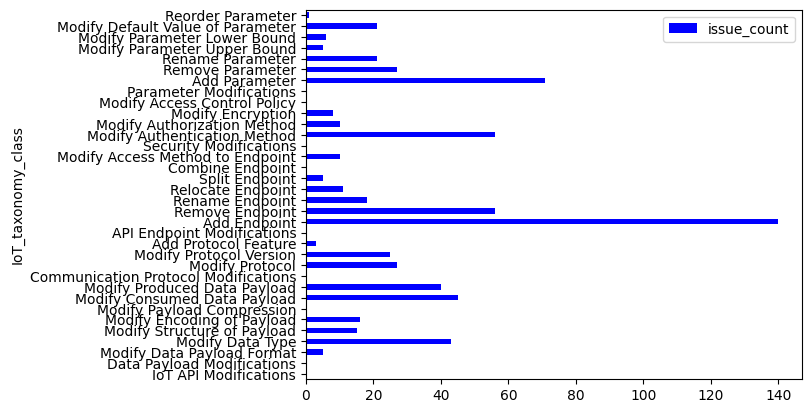

In [72]:
df = pd.DataFrame({'IoT_taxonomy_class': labels, 'issue_count': values})
df.to_csv("api_taxonomy_classification.csv", index=False)
df.plot(kind='barh', x='IoT_taxonomy_class', y='issue_count', color='blue')

## What are the different API integration scenarios and how do they change?
- (1) Analyze first different Integration Scenarios and identify the most relevant
- (2) Analyze the correlation between breaking changes and dimensions

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_dataframe_from_dict_list(data):
    """
    Create a pandas DataFrame from a list of dictionaries.
    
    :param data: List of dictionaries containing integration data
    :return: pandas DataFrame
    """
    return pd.DataFrame(data)

# Example usage
data = integration_data

# Create DataFrame
df = create_dataframe_from_dict_list(data)


In [56]:
df[['deployment_type', 'communication_method', 'integration_type']].value_counts()

deployment_type  communication_method  integration_type
Cloud            Polling               PlatformApi         70
Local            Polling               DeviceApi           44
                                       GatewayApi          28
                 Push                  DeviceApi           25
                 Polling               PlatformApi         24
Cloud            Push                  PlatformApi         24
Local            Push                  GatewayApi          23
                                       PlatformApi         20
Cloud            Polling               DeviceApi            7
                                       GatewayApi           6
                 Push                  GatewayApi           2
                                       DeviceApi            1
Name: count, dtype: int64

In [57]:
grouped_df = df.groupby(['deployment_type', 'integration_type', 'communication_method'])['changes'].sum().reset_index().sort_values('changes', ascending=False)

# Display the result
print(grouped_df)

   deployment_type integration_type communication_method  changes
4            Cloud      PlatformApi              Polling      242
6            Local        DeviceApi              Polling      185
5            Cloud      PlatformApi                 Push      158
7            Local        DeviceApi                 Push      151
8            Local       GatewayApi              Polling      146
9            Local       GatewayApi                 Push      128
11           Local      PlatformApi                 Push       88
10           Local      PlatformApi              Polling       79
0            Cloud        DeviceApi              Polling       15
2            Cloud       GatewayApi              Polling       13
3            Cloud       GatewayApi                 Push        5
1            Cloud        DeviceApi                 Push        1


### The most relevant deployment types are:
- (S1) Platform API & Polling Communication & Cloud Integration
- (S2) Device API & Polling Communication & Local Integration
- (S3) Gateway API & Polling Communication & Local Integration
- (S4) Device API & Push Communication & Local Integration
- (S5) Platform API & Push Communication & Cloud Integration
- (S6) Gateway API & Push Communication & Local Integration

In [58]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues



#### PlatformApi + Polling + Local

In [61]:

ppc_df = df[(df['integration_type'] == 'PlatformApi') & 
            (df['communication_method'] == 'Polling') & 
            (df['deployment_type'] == 'Cloud')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/2316826942.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/2316826942.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,-0.08,-0.12,-0.17,0.2,0.5***
communication_protocol_modifications,-0.08,1.0***,0.18,0.19,-0.07,0.29*
api_endpoint_modifications,-0.12,0.18,1.0***,0.11,-0.0,0.25*
security_modifications,-0.17,0.19,0.11,1.0***,0.07,0.55***
parameter_modifications,0.2,-0.07,-0.0,0.07,1.0***,0.44***
breaking_changes,0.5***,0.29*,0.25*,0.55***,0.44***,1.0***


#### DeviceApi + Polling + Local

In [64]:

ppc_df = df[(df['integration_type'] == 'DeviceApi') & 
            (df['communication_method'] == 'Polling') & 
            (df['deployment_type'] == 'Local')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/1389482433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/1389482433.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,-0.11,-0.2,-0.08,0.0,0.98***
communication_protocol_modifications,-0.11,1.0***,-0.06,-0.13,-0.02,-0.08
api_endpoint_modifications,-0.2,-0.06,1.0***,-0.25,-0.05,-0.2
security_modifications,-0.08,-0.13,-0.25,1.0***,-0.08,-0.07
parameter_modifications,0.0,-0.02,-0.05,-0.08,1.0***,0.16
breaking_changes,0.98***,-0.08,-0.2,-0.07,0.16,1.0***


#### GatewayApi + Polling + Local

In [65]:
# GatewayApi + Polling + Local
ppc_df = df[(df['integration_type'] == 'GatewayApi') & 
            (df['communication_method'] == 'Polling') & 
            (df['deployment_type'] == 'Local')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/3909288671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/3909288671.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,0.22,0.31,0.23,0.73***,0.99***
communication_protocol_modifications,0.22,1.0***,0.37,-0.06,0.13,0.31
api_endpoint_modifications,0.31,0.37,1.0***,0.1,0.37,0.4*
security_modifications,0.23,-0.06,0.1,1.0***,0.22,0.3
parameter_modifications,0.73***,0.13,0.37,0.22,1.0***,0.74***
breaking_changes,0.99***,0.31,0.4*,0.3,0.74***,1.0***


#### DeviceApi + Push + Local

In [66]:
# DeviceApi + Push + Local
ppc_df = df[(df['integration_type'] == 'DeviceApi') & 
            (df['communication_method'] == 'Push') & 
            (df['deployment_type'] == 'Local')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/2316156856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/2316156856.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,-0.02,-0.18,-0.08,-0.04,0.94***
communication_protocol_modifications,-0.02,1.0***,0.05,-0.11,-0.13,0.14
api_endpoint_modifications,-0.18,0.05,1.0***,-0.05,-0.18,-0.15
security_modifications,-0.08,-0.11,-0.05,1.0***,-0.05,-0.08
parameter_modifications,-0.04,-0.13,-0.18,-0.05,1.0***,0.19
breaking_changes,0.94***,0.14,-0.15,-0.08,0.19,1.0***


#### PlatformApi + Push + Cloud

In [67]:
# PlatformApi + Push + Cloud
ppc_df = df[(df['integration_type'] == 'PlatformApi') & 
            (df['communication_method'] == 'Push') & 
            (df['deployment_type'] == 'Cloud')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/1001319118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/1001319118.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,0.79***,0.3,0.63***,0.51*,0.9***
communication_protocol_modifications,0.79***,1.0***,0.28,0.72***,0.44*,0.82***
api_endpoint_modifications,0.3,0.28,1.0***,0.14,0.13,0.39
security_modifications,0.63***,0.72***,0.14,1.0***,0.4,0.74***
parameter_modifications,0.51*,0.44*,0.13,0.4,1.0***,0.59**
breaking_changes,0.9***,0.82***,0.39,0.74***,0.59**,1.0***


#### GatewayApi + Push + Local

In [68]:
# GatewayApi + Push + Local
ppc_df = df[(df['integration_type'] == 'GatewayApi') & 
            (df['communication_method'] == 'Push') & 
            (df['deployment_type'] == 'Local')]
ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
 # Select numeric and boolean columns for correlation analysis
numeric_and_bool_columns = ppc_df.select_dtypes(include=[np.number, bool]).columns
rho = ppc_df[numeric_and_bool_columns].corr()
pval = ppc_df[numeric_and_bool_columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

/tmp/ipykernel_25571/966255764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppc_df.drop(columns=['integration_type', 'communication_method', 'deployment_type', 'changes'], inplace=True)
/tmp/ipykernel_25571/966255764.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,data_payload_modifications,communication_protocol_modifications,api_endpoint_modifications,security_modifications,parameter_modifications,breaking_changes
data_payload_modifications,1.0***,-0.28,0.05,-0.24,-0.2,0.38
communication_protocol_modifications,-0.28,1.0***,-0.13,-0.18,-0.04,-0.15
api_endpoint_modifications,0.05,-0.13,1.0***,0.02,-0.07,0.28
security_modifications,-0.24,-0.18,0.02,1.0***,0.02,0.05
parameter_modifications,-0.2,-0.04,-0.07,0.02,1.0***,0.51*
breaking_changes,0.38,-0.15,0.28,0.05,0.51*,1.0***
